# Topic modeling

This notebook demonstrates how can you use topic modeling techniques to discover the topics which court decisions are about.

## Dataset access

Before running the notebook you need to get access to the dataset on Huggingface:
- Go to HF hub: https://huggingface.co/datasets/openlegaldata/court-decisions-germany
- Create a HF account or login if you already have one
- Apply for dataset access (automatic approval)

## Dependencies

```bash
# Install required packages for LDA topic modeling
pip install "scikit-learn>=1.3.0" "gensim>=4.0.0" "numpy>=1.21.0,<2.0.0" wordcloud matplotlib seaborn
```

In [1]:
import json
import re

import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings

from IPython.display import Markdown, display

from datasets import load_dataset

warnings.filterwarnings('ignore')


In [ ]:
!hf auth login

In [2]:
# Select the dump you want to use
# dataset_config = "dump-20221018"  # full datasets (~ 250k records)
dataset_config = "dump-20221018-10k" # 10k records
# dataset_config = "dump-20221018-1k"  # 1k records

# Download the dataset
ds = load_dataset("openlegaldata/court-decisions-germany", dataset_config, split="train")


Resolving data files:   0%|          | 0/26 [00:00<?, ?it/s]

In [3]:
# Let's look at a dataset sample
for example in iter(ds):
    print(json.dumps(example, indent=4))
    break

{
    "id": 325566,
    "slug": "lg-koln-2029-11-13-84-o-24918",
    "court": {
        "city": 446,
        "id": 812,
        "jurisdiction": "Ordentliche Gerichtsbarkeit",
        "level_of_appeal": "Landgericht",
        "name": "Landgericht K\u00f6ln",
        "slug": "lg-koln",
        "state": 12
    },
    "file_number": "84 O 249/18",
    "date": "2029-11-13",
    "created_date": "2020-02-06T11:01:05Z",
    "updated_date": "2020-12-10T13:50:38Z",
    "type": "Urteil",
    "ecli": "ECLI:DE:LGK:2029:1113.84O249.18.00",
    "content": "<h2>Tenor</h2>\n\n<ul class=\"ol\"><li><p>I. Die Beklagte wird verurteilt, der Kl\u00e4gerin vollst\u00e4ndige schriftliche Auskunft dar\u00fcber zu erteilen, in welchem Umfang die Beklagte im gesch\u00e4ftlichen Verkehr in Deutschland Hosen wie nachfolgend eingeblendet</p>\n</li>\n</ul>\n<p>\u00a0\u00a0\u00a0\u00a0\u00a0\u00a0\u00a0\u00a0\u00a0\u00a0\u00a0 (Es folgt eine Darstellung)</p>\n<p>angeboten und/oder beworben und/oder vertrieben hat und 

In [18]:
# Some additional processing: Remove standalone numbers on their own lines

def remove_line_numbers(text):
    # Remove lines that contain only digits (with optional whitespace)
    return re.sub(r'\n\s*\d+\s*\n', '\n\n', text)

def get_year_month_from_date_string(date_str: str) -> str:
    """Convert date string to year-month (invalid dates return empty string)"""
    import re
    from datetime import datetime
    
    if not date_str or pd.isna(date_str):
        return ""
    
    try:
        # Try common date formats
        for fmt in ['%Y-%m-%d', '%d.%m.%Y', '%d/%m/%Y', '%Y-%m-%d %H:%M:%S']:
            try:
                dt = datetime.strptime(str(date_str).strip(), fmt)
                return f"{dt.year}-{dt.month:02d}"
            except ValueError:
                continue
        
        # Extract year and month using regex
        # Try YYYY-MM or YYYY/MM patterns first
        year_month_match = re.search(r'(\d{4})[-/](\d{1,2})', str(date_str))
        if year_month_match:
            year, month = int(year_month_match.group(1)), int(year_month_match.group(2))
            if 1900 <= year <= 2030 and 1 <= month <= 12:
                return f"{year}-{month:02d}"
        
        # Try DD.MM.YYYY or DD/MM/YYYY patterns
        day_month_year_match = re.search(r'(\d{1,2})[\./](\d{1,2})[\./](\d{4})', str(date_str))
        if day_month_year_match:
            day, month, year = int(day_month_year_match.group(1)), int(day_month_year_match.group(2)), int(day_month_year_match.group(3))
            if 1900 <= year <= 2030 and 1 <= month <= 12:
                return f"{year}-{month:02d}"
        
        return ""
    except:
        return ""

def get_year_from_date_string(date_str: str) -> int:
    """Convert date string to year (invalid dates return year = 0)"""
    year_month = get_year_month_from_date_string(date_str)
    if year_month:
        return int(year_month.split('-')[0])
    return 0

def process_case(example):
    example["markdown_content"] = remove_line_numbers(example["markdown_content"])
    example["year"] = get_year_from_date_string(example["date"])
    example["year_month"] = get_year_month_from_date_string(example["date"])

    return example

ds = ds.map(process_case, batched=False)

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [5]:
# We will use the preprocessed markdown content (markdown_content)
display(Markdown(ds["markdown_content"][0][:5_000]))

## Tenor

- I. Die Beklagte wird verurteilt, der Klägerin vollständige schriftliche Auskunft darüber zu erteilen, in welchem Umfang die Beklagte im geschäftlichen Verkehr in Deutschland Hosen wie nachfolgend eingeblendet

            (Es folgt eine Darstellung)

angeboten und/oder beworben und/oder vertrieben hat und zwar insbesondere durch Vorlage eines Verzeichnisses, aus dem sich je Produktart ergibt:

- Namen und Anschrift der gewerblichen Abnehmer der oben abgebildeten Hosen und Verkaufsstellen, für die sie bestimmt waren bzw. an die sie geliefert worden sind; und

- die Menge der ausgelieferten, erhaltenen oder bestellten oben abgebildeten Hosen sowie die Preise, die für diese von ihren Abnehmern bezahlt wurden, sowie die entsprechenden Einstandspreise für die Produkte;

- der Umfang der für die oben abgebildeten Hosen betriebenen Werbung, unter Mitteilung der Werbemedien und ihrer Erscheinungsdaten und Auflagenzahlen, Sendedaten und -reichweiten, Veröffentlichungen im Internet und Zugriffszahlen auf diese Inhalte, sowie vergleichbare Angaben für andere Medien.

II. Die Beklagte wird verurteilt, die zu erteilenden Auskünfte nach Ziffer I. im Wege der Vorlage sämtlicher Lieferverträge, Auftragsbestätigungen, Rechnungen, Lieferbescheinigungen, Quittungen, jeweils sowohl für den Einkauf als auch für den Verkauf der Ware zu belegen und daraus nach Art einer geordneten Rechnungsaufstellung die in Ziffer I. genannten Auskünfte schlüssig und nachvollziehbar darzulegen.

III. Es wird festgestellt, dass die Beklagte verpflichtet ist, der Klägerin sämtliche durch die Verletzungshandlung gemäß Ziffer I. entstandenen oder zukünftig entstehenden Schäden zu ersetzen.

IV. Die Kosten des Rechtsstreits trägt die Beklagte.

V. Das Urteil ist hinsichtlich II. und III. gegen Sicherheitsleitung in Höhe von 15.000,00 € und hinsichtlich der Kosten in Höhe von 110% des jeweils zu vollstreckenden Betrages vorläufig vollstreckbar.

**T a t b e s t a n d :**

Die Klägerin behauptet, sie sei Alleinimporteurin und ausschließlich Vertriebsberechtigte in Deutschland der Produkte der Marke „Y“ der aus Z. Die X ist ein Modeunternehmen. Die unter der Marke „Y“ angebotenen Damenbekleidungsartikel sollen insbesondere die Zielgruppe „Trendy“ der jungen, 14-29jährigen, modebewussten Damen ansprechen. Hierzu gehören auch Jeansmodelle.

Die Klägerin trägt hierzu vor: Die „Y“-Jeans würden von der X hergestellt und in Deutschland in den großen und bekannten Bekleidungsgeschäften angeboten (Breuninger, Konen, Ludwig Beck, Engelhorn, Daniels oder Leo’s). Hauptwettbewerber in diesem Bereich seien Hersteller wie G-Star, Diesel, Replay, Tommy Hilfiger, Closed, Cambio, Herrlicher, Pepe Jeans, Drykorn, Levi’s und Scotch & Soda. Das erfolgreichste Jeansmodell der Marke „Y“ sei das Modell „P78A“, dieses werde seit Frühjahr 2010 auch auf dem deutschen Markt angeboten. Weiter würden noch zwei weitere Modelle „P68C“ und „P82D“, die charakteristische Merkmale der „P78A“ aufwiesen, vertrieben; diese seien allerdings jeweils leicht anders geschnitten. „P68C“ sei als SLIM-Modell ausgestaltet (insbesondere für jüngere Käuferinnen), „P82D“ sei ein „MINI BAGGY“-Modell, dessen Beine eine leichte O-Form aufwiesen.

Wegen der Gestaltung der Jeansmodelle verweist die Kammer auf die vorgelegten Abbildungen sowie die zur Akte gereichten Originalprodukte.

Die besondere Gestaltung ihrer Jeans beschreibt die Klägerin wie folgt:

- V-förmige Nähte auf der Vorderseite der Hosenbeine,

- nicht verdeckte Knopfleiste am Hosenschlitz,

- zwei fast parallel geschwungene Nähte an den Vordertaschen,

- Gesäßtaschen aus drei sich überlappenden Teilen,

- zwei Reihen Doppelnähte auf der Hosenrückseite.

Sie, die Klägerin, habe in Deutschland das Modell „P78A“ wie folgt abgesetzt:

2010:       ca. 2.000 Stück (geschätzt)

2011:       ca. 4.000 Stück (geschätzt)

2012: über   26.000 Stück, Umsatz über 1 Mio. EUR

2013: über 195.000 Stück, Umsatz über 8 Mio. EUR

2014: über 407.000 Stück, Umsatz über 16 Mio. EUR

2015: über 308.000 Stück, Umsatz über 12 Mio. EUR

2016: über 215.000 Stück, Umsatz über   8 Mio. EUR

2017: über 200.000 Stück, Umsatz über 7,7 Mio. EUR

Die „Y“-Jeans hätten in Deutschland eine große Aufmerksamkeit erregt. Zahlreiche Modemagazine hätten hierüber berichtet. Die „Y“-Jeans würden umfangreich beworben. Hierzu trägt die Klägerin im Einzelnen vor.

Die Beklagte ist Teil des dänischen Unternehmens Bestseller, welches eines der größten europäischen Bekleidungsunternehmen ist.

Die streitgegenständlichen und im Tenor zu I. abgebildeten Hosen sind im Dezember 2017 von der Amazon EU S.à.r.l. auf deren Internetseite angeboten worden.

Wegen der Gestaltung der hier in Rede stehenden Jeans verweist die Kammer auf die zur Akte gereichten Abbildungen sowie auf das vorgelegte Originalprodukt.

Nach einer Abmahnung der Klägerin vom 20.12.2017 erteilte die Amazon EU S.à.r.l. die Auskunft, dass die streitgegenständlichen Hosen von der Beklagten geliefert worden seien. Darau

## LDA topic modeling

In [6]:
# Text preprocessing functions for German legal documents
class LegalTextPreprocessor:
    def __init__(self):
        # German legal stop words
        self.german_stopwords = set([
            'der', 'die', 'das', 'den', 'dem', 'des', 'und', 'oder', 'aber', 'doch', 
            'sondern', 'denn', 'nicht', 'auch', 'noch', 'schon', 'nur', 'bereits',
            'von', 'mit', 'nach', 'bei', 'zu', 'für', 'auf', 'an', 'in', 'über',
            'unter', 'durch', 'gegen', 'ohne', 'um', 'vor', 'hinter', 'neben',
            'ist', 'sind', 'war', 'waren', 'hat', 'haben', 'hatte', 'hatten',
            'wird', 'werden', 'wurde', 'wurden', 'sein', 'seine', 'seiner', 'seinem',
            'einen', 'eine', 'eines', 'einem', 'einer', 'kann', 'könnte', 'muss',
            'soll', 'sollte', 'würde', 'könnte', 'darf', 'darauf', 'damit', 'dabei',
            'insbesondere', 'wäre', 'selbst', 'sowie', 'wegen', 'ihre', 'könne', 'seien', 'ihre', 'ihr',
            'mai', 'juni', 'dezember', 'september', 'juli', 'januar', 'november', 'oktober',
            'habe', 'sei', 'worden', 'ihm', 'hätte', 'gewesen', 'insoweit', 'davon', 'angaben', 'diesem', 'geltend', 'aufgrund',
            # Legal specific stopwords
            'gericht', 'urteil', 'beschluss', 'entscheidung', 'verfahren', 'klage',
            'beklagte', 'kläger', 'antrag', 'berufung',
            'abs', 'vgl', 'juris', 'nrw', 'ziffer', 'kläger', 'klägerin', 'bzw', 'art', 'beklagten', 'antragsteller', 'antragstellerin', 'gemäß',
            'paragraph', 'artikel', 'satz', 'nr', 'lit', 'buchstabe', 'senat', 'vom', 'dies', 'hier', 'regelung', 'richtlinie', 'höhe', 'bescheid', 
            'dies', 'können', 'fall', 'hier', 'www', 'http', 'https',
            'weil', 'bis', 'link', 'true', 'verordnung', 'klägers',
            'antragstellers', 'antragsgegner', 'antragsgegnerin',
            'jedenfalls', 'jportal',
        ])
        
    def clean_text(self, text):
        """Clean and normalize text"""
        if not text or pd.isna(text):
            return ""
        
        # Convert to lowercase
        text = text.lower()
        
        # Remove special characters but keep umlauts
        import re
        text = re.sub(r'[^\w\säöüß]', ' ', text)
        
        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()
        
        # Remove very short words (less than 3 characters)
        words = [word for word in text.split() if len(word) >= 3]
        
        # Remove stopwords
        words = [word for word in words if word not in self.german_stopwords]
        
        return ' '.join(words)
    
    def chunk_document(self, text, max_tokens=1000, overlap=200):
        """Split long documents into overlapping chunks"""
        if not text:
            return []
        
        words = text.split()
        if len(words) <= max_tokens:
            return [text]
        
        chunks = []
        start = 0
        
        while start < len(words):
            end = min(start + max_tokens, len(words))
            chunk = ' '.join(words[start:end])
            chunks.append(chunk)
            
            if end == len(words):
                break
                
            start = end - overlap
            
        return chunks

# Initialize preprocessor
preprocessor = LegalTextPreprocessor()

In [7]:
# Process documents with chunking for long documents
print("Processing documents...")
processed_documents = []
document_metadata = []

for idx, doc in enumerate(ds):
    # Clean the markdown content
    cleaned_text = preprocessor.clean_text(doc['markdown_content'])
    
    # Chunk long documents
    chunks = preprocessor.chunk_document(cleaned_text, max_tokens=800, overlap=150)
    
    # Store chunks and metadata
    for chunk_idx, chunk in enumerate(chunks):
        if len(chunk.strip()) > 50:  # Only keep substantial chunks
            processed_documents.append(chunk)
            document_metadata.append({
                'original_doc_id': idx,
                'chunk_id': chunk_idx,
                'court': doc.get('court', 'Unknown'),
                'date': doc.get('date', 'Unknown'),
                'file_number': doc.get('file_number', 'Unknown')
            })

print(f"Created {len(processed_documents)} chunks from {len(ds)} documents")
print(f"Average chunks per document: {len(processed_documents)/len(ds):.1f}")

# Show sample of processed text
print(f"\nSample processed chunk:")
print(processed_documents[0][:300] + "...")

Processing documents...
Created 33913 chunks from 10000 documents
Average chunks per document: 3.4

Sample processed chunk:
tenor verurteilt vollständige schriftliche auskunft darüber erteilen welchem umfang geschäftlichen verkehr deutschland hosen wie nachfolgend eingeblendet folgt darstellung angeboten beworben vertrieben zwar vorlage verzeichnisses aus sich produktart ergibt namen anschrift gewerblichen abnehmer oben ...


In [8]:
# Scalable LDA implementation using scikit-learn
class ScalableLDA:
    def __init__(self, n_topics=10, max_features=5000, min_df=5, max_df=0.7):
        self.n_topics = n_topics
        self.max_features = max_features
        self.min_df = min_df
        self.max_df = max_df
        self.vectorizer = None
        self.lda_model = None
        self.feature_names = None
        
    def fit(self, documents):
        """Fit LDA model on documents"""
        print(f"Vectorizing {len(documents)} documents...")
        
        # Use CountVectorizer (LDA works better with counts than TF-IDF)
        self.vectorizer = CountVectorizer(
            max_features=self.max_features,
            min_df=self.min_df,  # Ignore terms in less than min_df documents
            max_df=self.max_df,  # Ignore terms in more than max_df% of documents
            ngram_range=(1, 2),  # Include unigrams and bigrams
            token_pattern=r'\b[a-zA-ZäöüßÄÖÜ]{3,}\b'  # German characters, min 3 chars
        )
        
        # Fit and transform documents
        doc_term_matrix = self.vectorizer.fit_transform(documents)
        self.feature_names = self.vectorizer.get_feature_names_out()
        
        print(f"Created vocabulary of {len(self.feature_names)} terms")
        print(f"Document-term matrix shape: {doc_term_matrix.shape}")
        
        # Fit LDA model
        print(f"Training LDA with {self.n_topics} topics...")
        self.lda_model = LatentDirichletAllocation(
            n_components=self.n_topics,
            max_iter=20,  # Reduced for faster training
            learning_method='batch',  # More stable for small datasets
            random_state=42,
            n_jobs=-1  # Use all CPU cores
        )
        
        # Fit the model
        doc_topic_matrix = self.lda_model.fit_transform(doc_term_matrix)
        
        return doc_topic_matrix
    
    def get_topic_words(self, n_words=10):
        """Get top words for each topic"""
        if not self.lda_model:
            return None
            
        topics = []
        for topic_idx, topic in enumerate(self.lda_model.components_):
            top_words_idx = topic.argsort()[-n_words:][::-1]
            top_words = [self.feature_names[i] for i in top_words_idx]
            top_weights = [topic[i] for i in top_words_idx]
            topics.append(list(zip(top_words, top_weights)))
        
        return topics
    
    def transform(self, documents):
        """Transform new documents to topic space"""
        if not self.vectorizer or not self.lda_model:
            raise ValueError("Model must be fitted first")
            
        doc_term_matrix = self.vectorizer.transform(documents)
        return self.lda_model.transform(doc_term_matrix)
    
    def get_perplexity(self, documents):
        """Calculate model perplexity (lower is better)"""
        if not self.vectorizer or not self.lda_model:
            return None
            
        doc_term_matrix = self.vectorizer.transform(documents)
        return self.lda_model.perplexity(doc_term_matrix)

# Initialize and train LDA model
lda = ScalableLDA(n_topics=25, max_features=3000, min_df=3, max_df=0.8)
doc_topic_matrix = lda.fit(processed_documents)

Vectorizing 33913 documents...
Created vocabulary of 3000 terms
Document-term matrix shape: (33913, 3000)
Training LDA with 25 topics...


In [9]:
# Topic Analysis and Visualization with Named Topics
def topic_words(lda_model, n_words=15):
    """Analyze and display topic results using named topics"""
    topics = lda_model.get_topic_words(n_words=n_words)
    
    # Display topics with names
    for topic_idx, topic_words in enumerate(topics):
        print(f"\nTopic {topic_idx +1 }:")

        # Show top words
        top_words = [word for word, weight in topic_words[:10]]
        print(f"Top words: {', '.join(top_words)}")

topic_words(lda)


Topic 1:
Top words: maustaste, wenn sie, kopieren, linke, halten, gedrückt, markieren, halten sie, einfügen, sie markieren

Topic 2:
Top words: daten, bundesnetzagentur, ermittlung, beschwerdeführerin, enwg, festlegung, rahmen, generellen, vorgaben, berechnung

Topic 3:
Top words: dass sich, mündlichen, mündlichen verhandlung, verhandlung, vortrag, dann, ihrer, mehr, zwar, verhalten

Topic 4:
Top words: ifsg, corona, covid, personen, cov, sars, sars cov, maßnahmen, coronavirus, rki

Topic 5:
Top words: vwgo, verwaltungsgericht, verwaltungsgerichts, ovg, frage, gkg, beschwerde, kostenentscheidung, bedeutung, bverwg

Topic 6:
Top words: vwgo, wirkung, anordnung, vollziehung, interesse, behörde, aufschiebende, aufschiebende wirkung, vwvfg, verwaltungsakt

Topic 7:
Top words: beigeladenen, tätigkeit, beamten, beigeladene, bverwg, beurteilung, ovg, auswahlentscheidung, bewerber, dienstherrn

Topic 8:
Top words: straße, grundstück, beigeladenen, vorhaben, nutzung, baugenehmigung, genehmigun

## Find names for topic clusters

LDA produces only topic IDs with words. To obtain human readable topic names we will use an LLM (like ChatGPT). Simply paste this prompt and the output of the cell above to your favorite LLM:

> Given a list of topic words (output of LDA topic modeling), generate a human readable name to each topic. The output should be a valid Python dictionary with topic ID (int) => topic name (str):

> {topic words from above}


In [10]:
topic_names = {
    1: "Text Editing & Copy-Paste Instructions",
    2: "Regulation & Energy Law (Bundesnetzagentur, EnWG)",
    3: "Oral Hearings & Court Proceedings",
    4: "COVID-19 & Infection Protection Law (IfSG, RKI)",
    5: "Administrative Court Procedures (VwGO, OVG, BVerwG)",
    6: "Suspensive Effect & Administrative Orders",
    7: "Civil Service & Recruitment Disputes",
    8: "Building Permits & Land Use Planning",
    9: "Civil Law & Case Law (BGB, ZPO, BGH, OLG)",
    10: "Medical Expertise & Patient Assessments",
    11: "Immigration & Asylum Law (AufenthG, AsylG, EMRK)",
    12: "Statutory Interpretation & Legal Provisions",
    13: "Tax Law & Family-related Cases (BFH, EStG)",
    14: "Legal Reasoning & Written Submissions",
    15: "Appeals & Regional Administrative Courts (NRW, OVG)",
    16: "Costs, Expenses & Financial Calculations",
    17: "Urban Development & Zoning (BauGB, Bebauungsplan)",
    18: "Social Law & Social Benefits (SGB, BSG, LSG)",
    19: "Country Reports & Refugee Situations (Afghanistan, etc.)",
    20: "Corona Regulations in Lower Saxony (Niedersachsen)",
    21: "Interim Legal Protection (Einstweilige Anordnung)",
    22: "Case Law in Baden-Württemberg (VGH, OVG, BVerfG)",
    23: "Criminal Law & Procedure (StPO, StGB, OLG)",
    24: "Constitutional Court & Fundamental Rights (BVerfG)",
    25: "Employment Termination & Labor Law (Kündigung, BAG)",
}



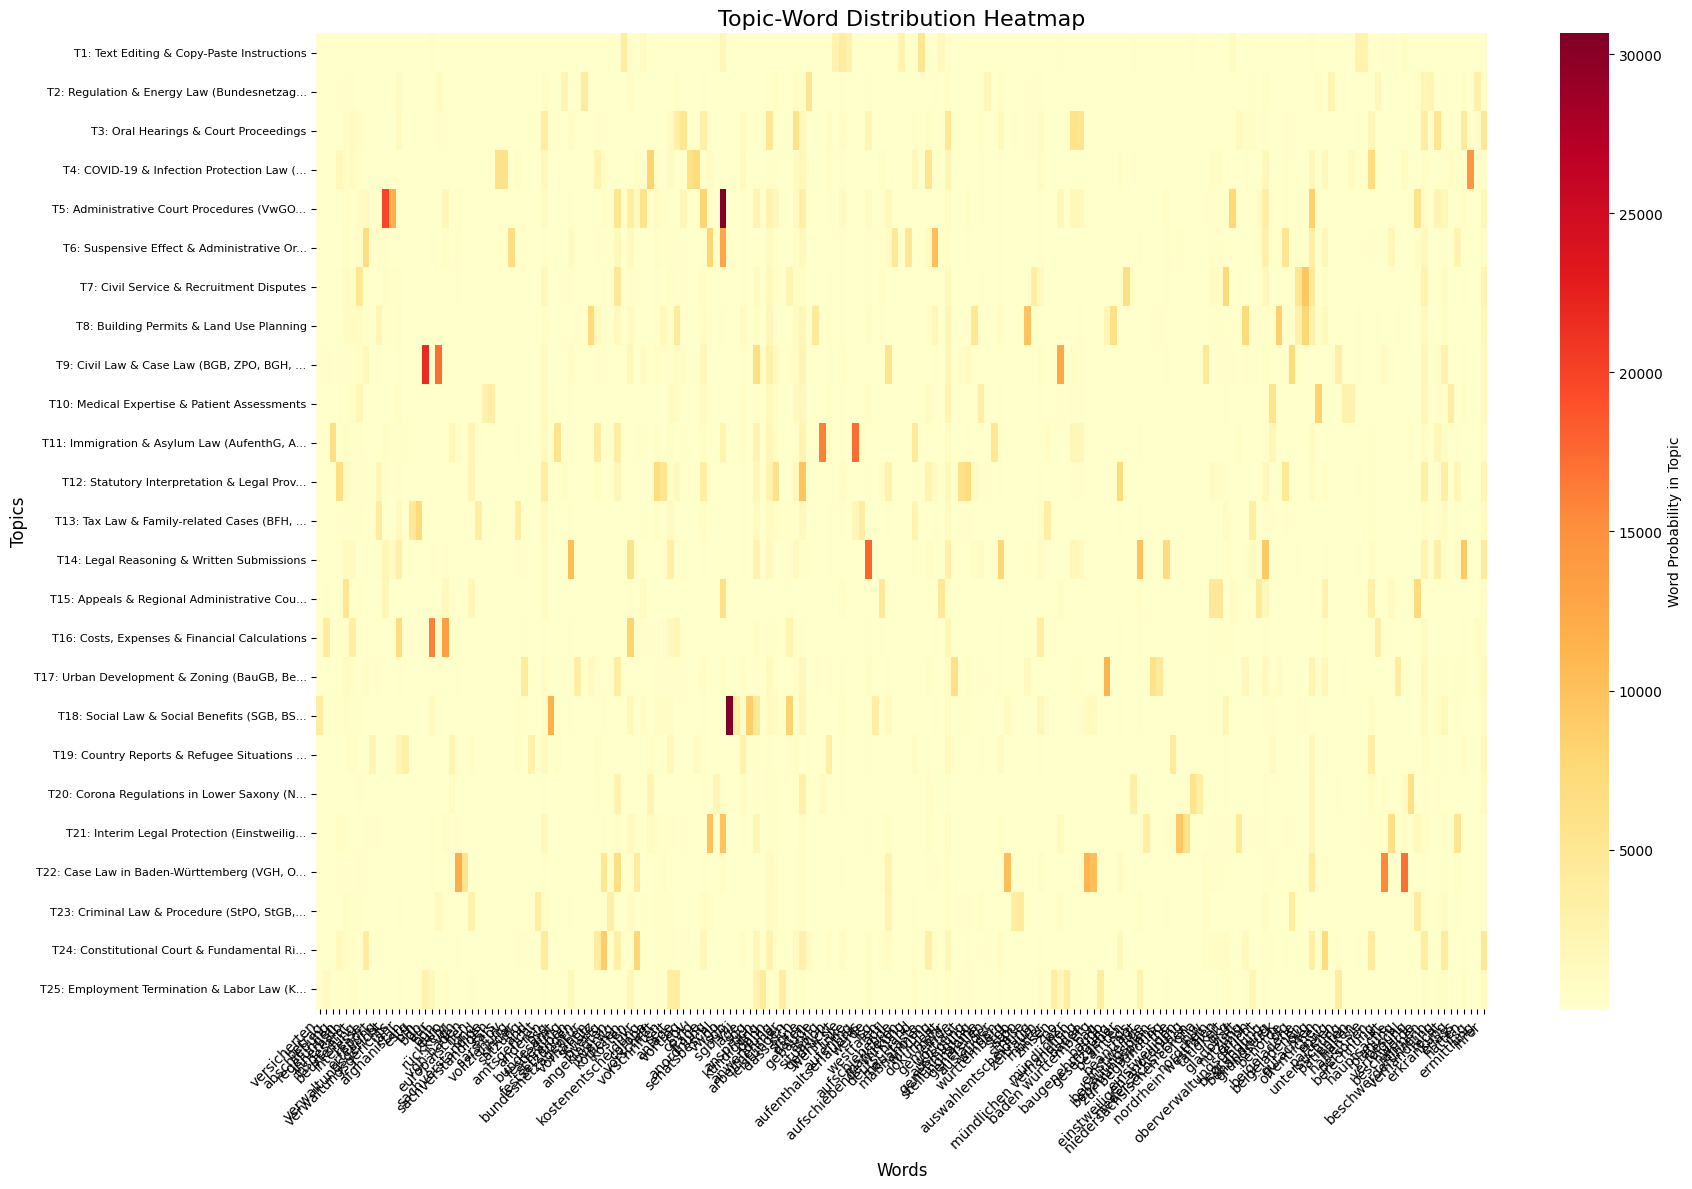

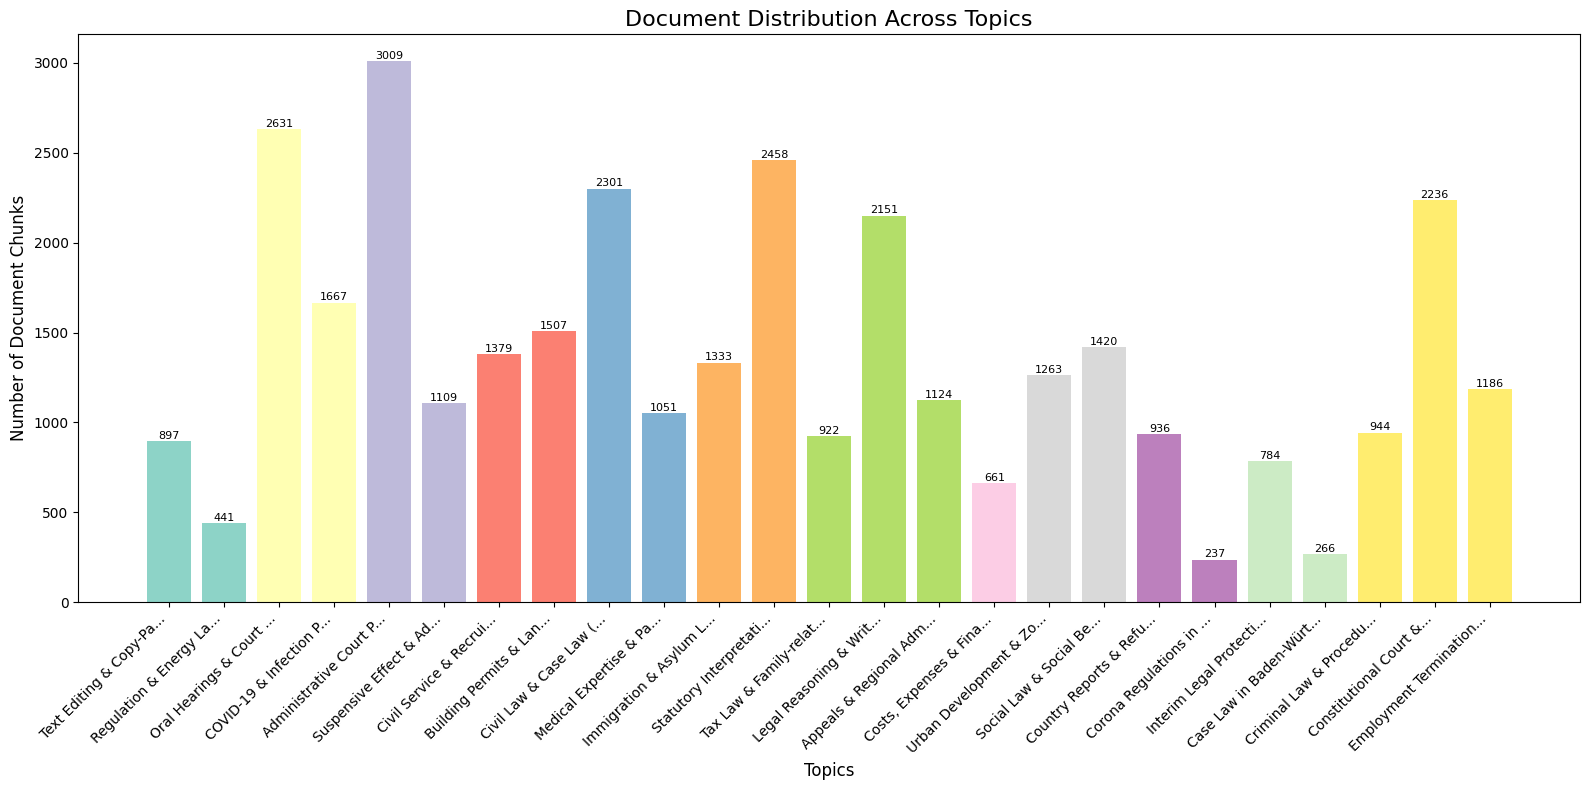

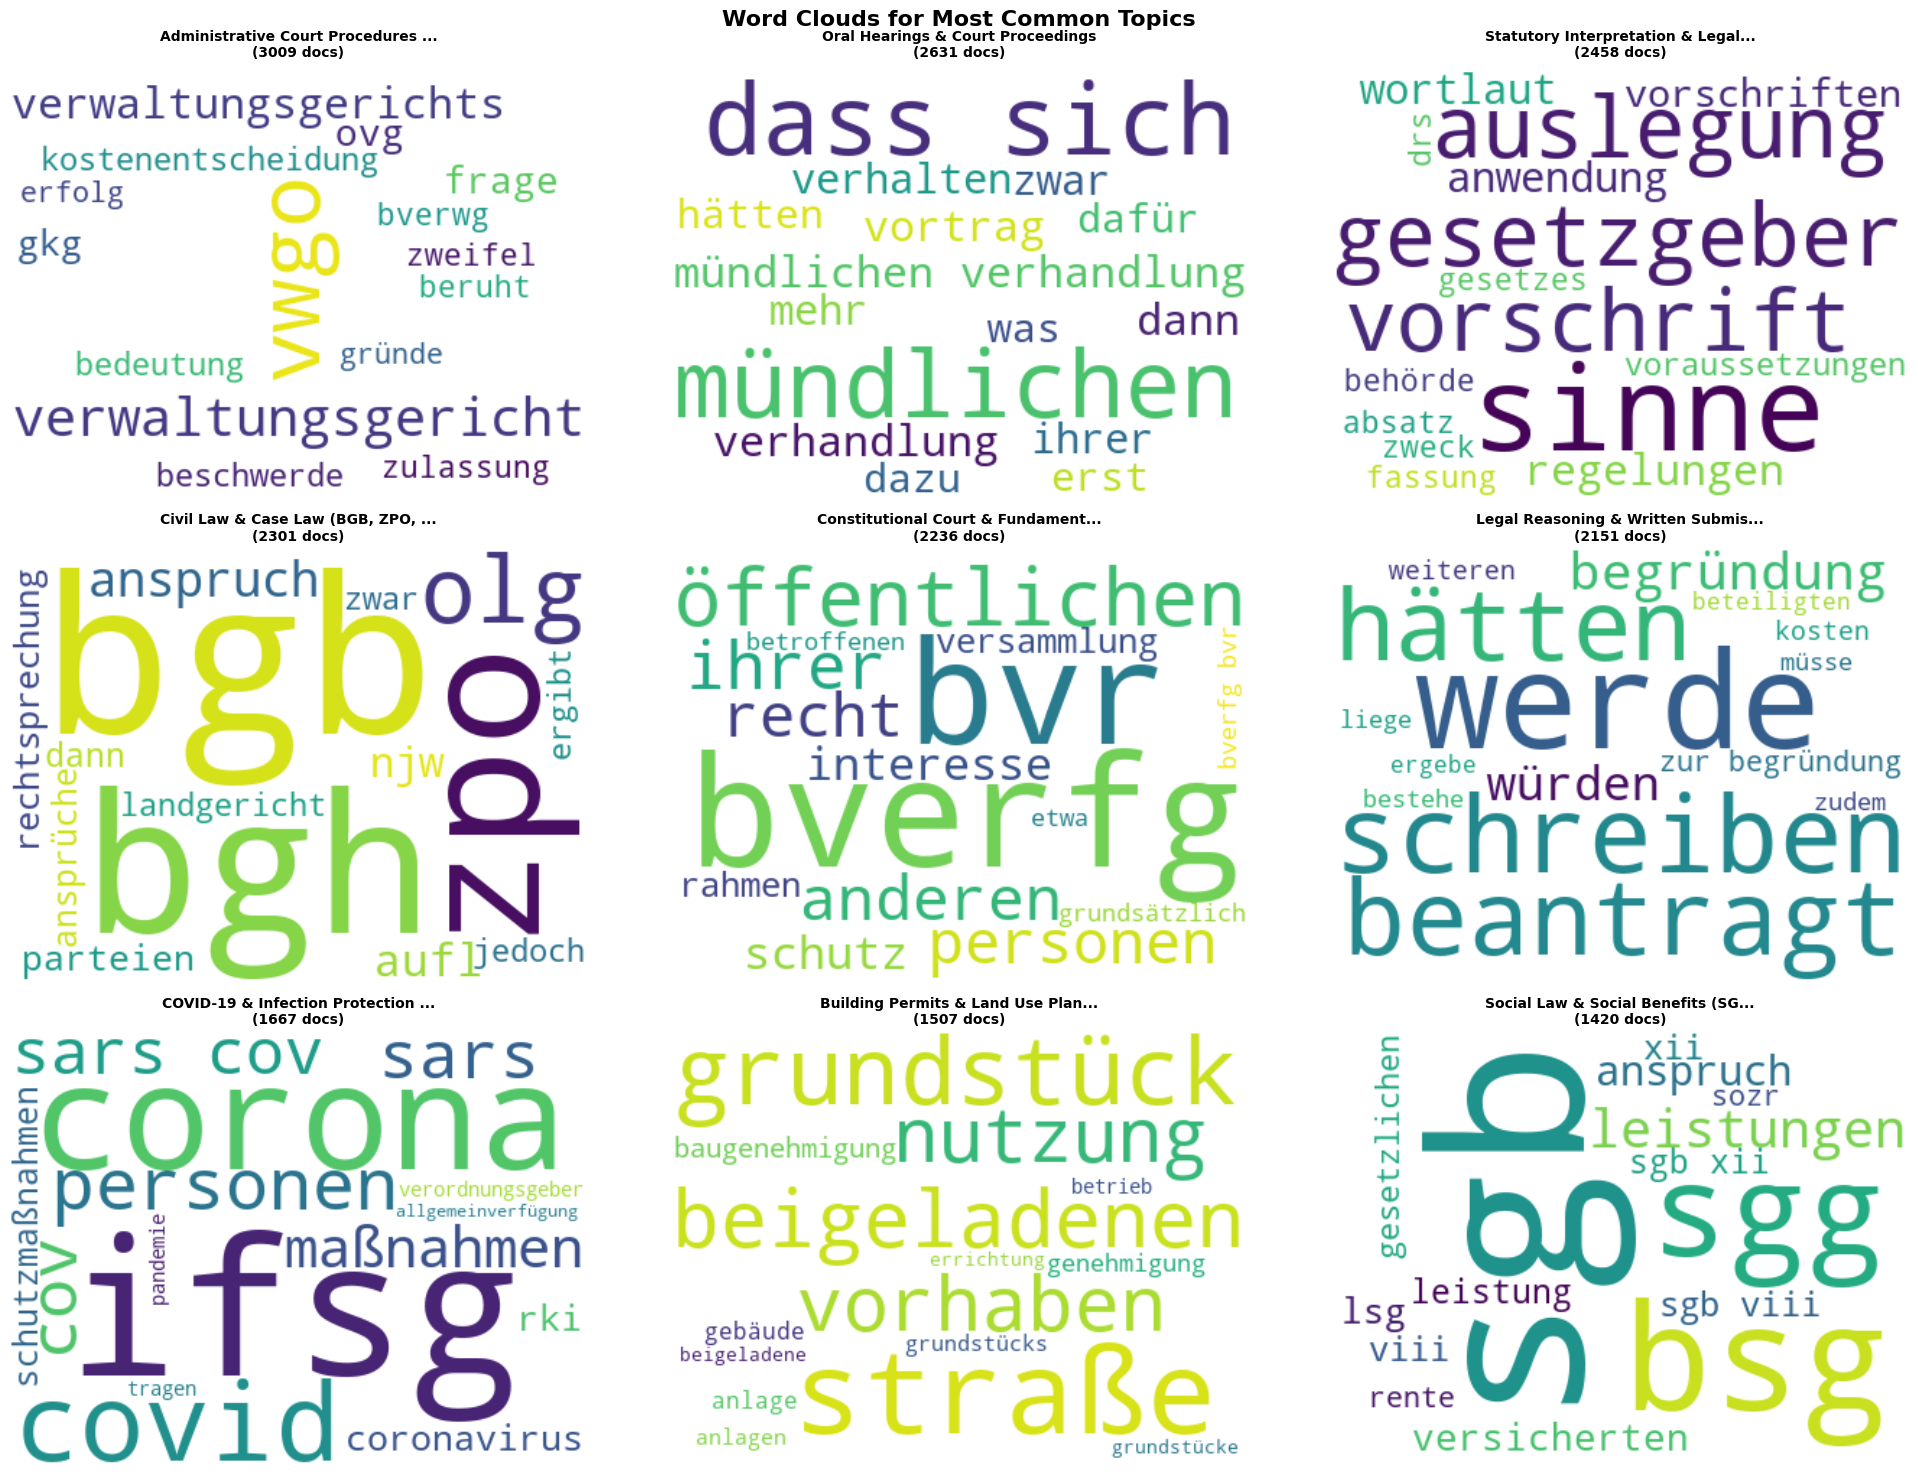

In [11]:
# Visualizations with Named Topics
def create_topic_visualizations(lda_model, doc_topic_matrix, topic_names):
    """Create various visualizations for topic analysis using named topics"""
    
    # 1. Topic-Word Heatmap
    plt.figure(figsize=(18, 12))
    
    # Get topic-word matrix
    topic_word_matrix = lda_model.lda_model.components_
    
    # Get top words for labeling
    topics = lda_model.get_topic_words(n_words=10)
    
    # Use named topics for labels, truncated for readability
    topic_labels = []
    for i, topic in enumerate(topics):
        topic_name = topic_names.get(i + 1, f"Topic {i + 1}")
        # Truncate long names
        if len(topic_name) > 40:
            topic_name = topic_name[:37] + "..."
        topic_labels.append(f"T{i+1}: {topic_name}")
    
    # Create heatmap of top words across topics
    top_words_indices = []
    for topic in topics:
        top_words_indices.extend([lda_model.feature_names.tolist().index(word) for word, _ in topic[:8]])
    
    # Get unique top words
    unique_indices = list(set(top_words_indices))
    word_labels = [lda_model.feature_names[i] for i in unique_indices]
    
    # Create subset matrix
    subset_matrix = topic_word_matrix[:, unique_indices]
    
    # Plot heatmap
    sns.heatmap(subset_matrix, 
                xticklabels=word_labels, 
                yticklabels=topic_labels,
                cmap='YlOrRd', 
                cbar_kws={'label': 'Word Probability in Topic'})
    
    plt.title('Topic-Word Distribution Heatmap', fontsize=16)
    plt.xlabel('Words', fontsize=12)
    plt.ylabel('Topics', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0, fontsize=8)
    plt.tight_layout()
    plt.show()
    
    # 2. Topic Distribution Bar Chart
    plt.figure(figsize=(16, 8))
    
    dominant_topics = np.argmax(doc_topic_matrix, axis=1)
    topic_counts = Counter(dominant_topics)
    
    # Create labels with topic names
    topic_labels = []
    counts_list = []
    
    for i in range(lda_model.n_topics):
        topic_name = topic_names.get(i + 1, f"Topic {i + 1}")
        # Truncate for x-axis readability
        if len(topic_name) > 25:
            topic_name = topic_name[:22] + "..."
        topic_labels.append(topic_name)
        counts_list.append(topic_counts.get(i, 0))
    
    bars = plt.bar(range(len(topic_labels)), counts_list, 
                   color=plt.cm.Set3(np.linspace(0, 1, len(topic_labels))))
    
    plt.title('Document Distribution Across Topics', fontsize=16)
    plt.xlabel('Topics', fontsize=12)
    plt.ylabel('Number of Document Chunks', fontsize=12)
    plt.xticks(range(len(topic_labels)), topic_labels, rotation=45, ha='right')
    
    # Add value labels on bars
    for i, bar in enumerate(bars):
        height = bar.get_height()
        if height > 0:  # Only label non-zero bars
            plt.text(bar.get_x() + bar.get_width()/2., height + 1,
                    f'{int(height)}', ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    # 3. Word Clouds for Top Topics (by document count)
    fig, axes = plt.subplots(3, 3, figsize=(20, 15))
    axes = axes.flatten()
    
    topics = lda_model.get_topic_words(n_words=20)
    
    # Get top topics by document count
    topic_counts_sorted = sorted(topic_counts.items(), key=lambda x: x[1], reverse=True)
    
    for i, (topic_idx, count) in enumerate(topic_counts_sorted[:9]):  # Top 9 topics
        if i >= len(axes):
            break
            
        topic_words = topics[topic_idx]
        topic_name = topic_names.get(topic_idx + 1, f"Topic {topic_idx + 1}")
        
        # Create word frequency dict for wordcloud
        word_freq = {word: weight for word, weight in topic_words}
        
        # Generate word cloud
        wordcloud = WordCloud(
            width=400, height=300, 
            background_color='white',
            colormap='viridis',
            max_words=15,
            relative_scaling=0.5,
            min_font_size=10
        ).generate_from_frequencies(word_freq)
        
        axes[i].imshow(wordcloud, interpolation='bilinear')
        axes[i].axis('off')
        
        # Truncate title if too long
        title = topic_name if len(topic_name) <= 35 else topic_name[:32] + "..."
        axes[i].set_title(f'{title}\n({count} docs)', fontsize=10, fontweight='bold')
    
    # Hide unused subplots
    for j in range(len(topic_counts_sorted), len(axes)):
        axes[j].axis('off')
    
    plt.suptitle('Word Clouds for Most Common Topics', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Create visualizations with topic names
create_topic_visualizations(lda, doc_topic_matrix, topic_names)

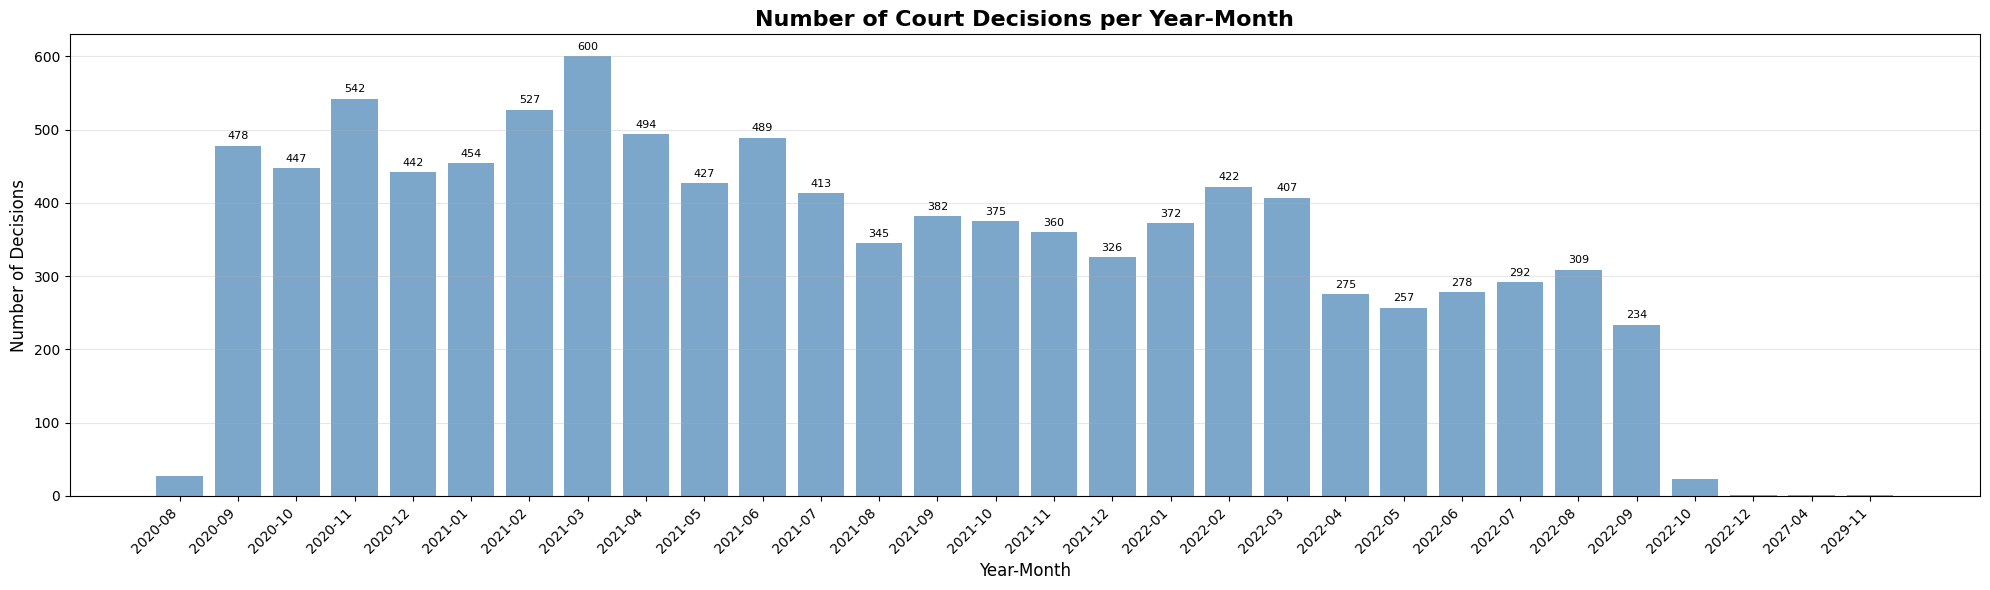

Total decisions with valid year-months: 10000
Time range: 2020-08 to 2029-11
Peak month: 2021-03 with 600 decisions


In [19]:
# let's plot the number of court decisions per year-month as a bar chart

# Extract year-months from the dataset
year_months = [doc['year_month'] for doc in ds if doc['year_month']]  # Filter out empty year-months
year_month_counts = Counter(year_months)

# Sort year-months for proper chronological order
sorted_year_months = sorted(year_month_counts.keys())
counts = [year_month_counts[ym] for ym in sorted_year_months]

# Create bar chart
plt.figure(figsize=(20, 6))
bars = plt.bar(range(len(sorted_year_months)), counts, color='steelblue', alpha=0.7)

plt.title('Number of Court Decisions per Year-Month', fontsize=16, fontweight='bold')
plt.xlabel('Year-Month', fontsize=12)
plt.ylabel('Number of Decisions', fontsize=12)
plt.grid(axis='y', alpha=0.3)

# Set x-axis labels - show every 6th month to avoid overcrowding
step = max(1, len(sorted_year_months) // 20)  # Show ~20 labels max
x_ticks = range(0, len(sorted_year_months), step)
x_labels = [sorted_year_months[i] for i in x_ticks]
plt.xticks(x_ticks, x_labels, rotation=45, ha='right')

# Add value labels on bars (only for higher bars to avoid clutter)
max_height = max(counts) if counts else 0
threshold = max_height * 0.3  # Only label bars above 30% of max height

for i, bar in enumerate(bars):
    height = bar.get_height()
    if height > threshold:
        plt.text(bar.get_x() + bar.get_width()/2., height + max_height * 0.01,
                f'{int(height)}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

if sorted_year_months:
    print(f"Total decisions with valid year-months: {len(year_months)}")
    print(f"Time range: {sorted_year_months[0]} to {sorted_year_months[-1]}")
    peak_month = max(year_month_counts.items(), key=lambda x: x[1])
    print(f"Peak month: {peak_month[0]} with {peak_month[1]} decisions")
else:
    print("No valid year-month data found")

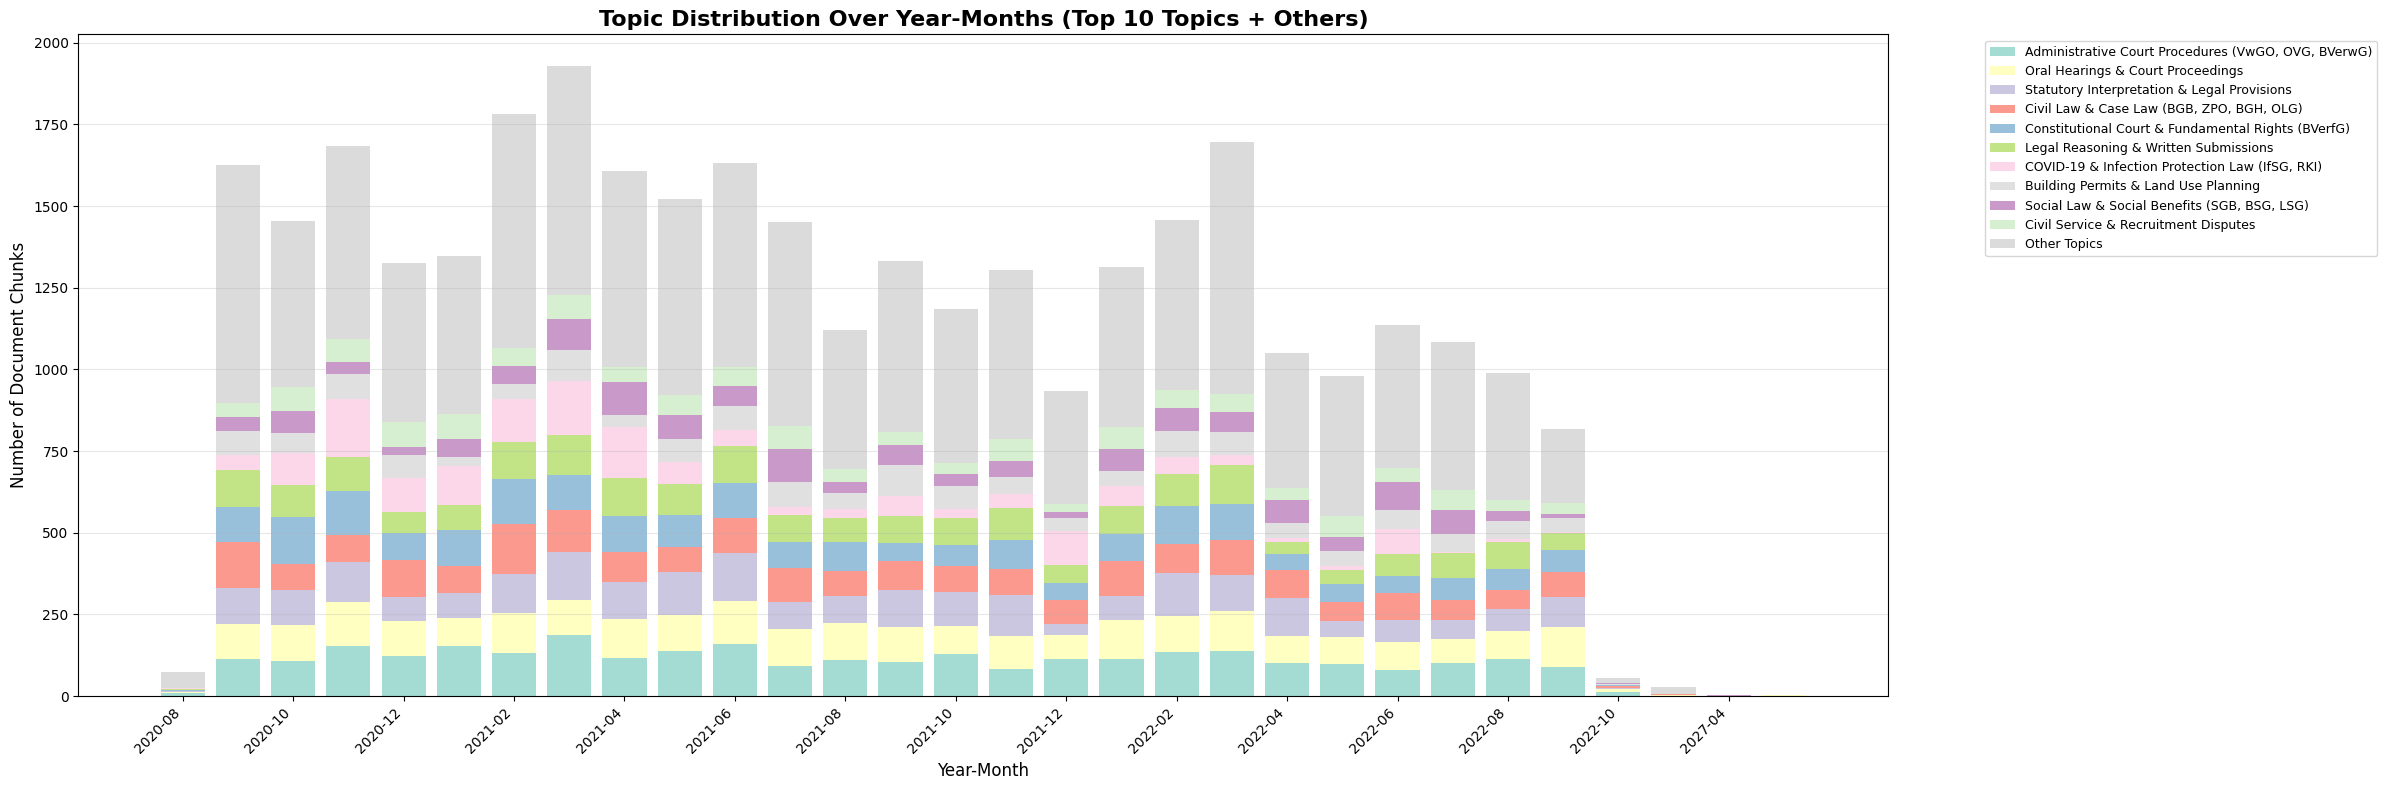

TOPIC EVOLUTION OVER YEAR-MONTHS - SUMMARY
Time period covered: 2020-08 to 2029-11
Top 5 topics by overall frequency:
  1. Administrative Court Procedures (VwGO, OVG, BVerwG): 3009 chunks (8.9%)
  2. Oral Hearings & Court Proceedings: 2631 chunks (7.8%)
  3. Statutory Interpretation & Legal Provisions: 2458 chunks (7.2%)
  4. Civil Law & Case Law (BGB, ZPO, BGH, OLG): 2301 chunks (6.8%)
  5. Constitutional Court & Fundamental Rights (BVerfG): 2236 chunks (6.6%)
  6. Legal Reasoning & Written Submissions: 2151 chunks (6.3%)
  7. COVID-19 & Infection Protection Law (IfSG, RKI): 1667 chunks (4.9%)
  8. Building Permits & Land Use Planning: 1507 chunks (4.4%)
  9. Social Law & Social Benefits (SGB, BSG, LSG): 1420 chunks (4.2%)
  10. Civil Service & Recruitment Disputes: 1379 chunks (4.1%)

Peak month: 2021-03 with 1929 document chunks


In [21]:
# plot the topics per year-month as a stacked bar plot (only the top k topics are shown, everything else is "other topics")

top_k = 10

# Get dominant topics for each chunk
dominant_topics = np.argmax(doc_topic_matrix, axis=1)

# Create mapping from chunk to original document
chunk_to_doc = {}
for idx, metadata in enumerate(document_metadata):
    chunk_to_doc[idx] = metadata['original_doc_id']

# Get year-months for each chunk based on original document
chunk_year_months = []
for idx in range(len(processed_documents)):
    doc_id = chunk_to_doc[idx]
    year_month = ds[doc_id]['year_month']
    chunk_year_months.append(year_month if year_month else None)

# Create topic-year-month combinations
topic_year_month_data = []
for chunk_idx, (topic_id, year_month) in enumerate(zip(dominant_topics, chunk_year_months)):
    if year_month is not None:  # Only include valid year-months
        topic_year_month_data.append({
            'topic_id': topic_id,
            'topic_name': topic_names.get(topic_id + 1, f"Topic {topic_id + 1}"),
            'year_month': year_month
        })

# Convert to DataFrame for easier manipulation

df_topics_year_months = pd.DataFrame(topic_year_month_data)

if len(df_topics_year_months) == 0:
    print("No valid year-month data found for topic analysis")
else:
    # Find top 5 topics overall
    top_topics = df_topics_year_months['topic_id'].value_counts().head(top_k).index.tolist()
    top_topic_names = [topic_names.get(tid + 1, f"Topic {tid + 1}") for tid in top_topics]

    # Group other topics
    df_topics_year_months['topic_group'] = df_topics_year_months['topic_id'].apply(
        lambda x: topic_names.get(x + 1, f"Topic {x + 1}") if x in top_topics else "Other Topics"
    )

    # Create pivot table for stacked bar chart
    pivot_table = df_topics_year_months.groupby(['year_month', 'topic_group']).size().unstack(fill_value=0)

    # Ensure "Other Topics" is last column if it exists
    columns_order = top_topic_names[:]
    if "Other Topics" in pivot_table.columns:
        columns_order.append("Other Topics")

    # Reorder columns
    pivot_table = pivot_table.reindex(columns=columns_order, fill_value=0)

    # Create stacked bar chart
    plt.figure(figsize=(24, 8))

    # Define colors
    colors = plt.cm.Set3(np.linspace(0, 1, len(pivot_table.columns)))
    colors_dict = dict(zip(pivot_table.columns, colors))
    # Make "Other Topics" gray if it exists
    if "Other Topics" in colors_dict:
        colors_dict["Other Topics"] = 'lightgray'

    # Create stacked bars
    bottom = np.zeros(len(pivot_table.index))
    bars = []

    for i, column in enumerate(pivot_table.columns):
        bar = plt.bar(range(len(pivot_table.index)), pivot_table[column], 
                      bottom=bottom, label=column, 
                      color=colors_dict[column], alpha=0.8)
        bars.append(bar)
        bottom += pivot_table[column]

    plt.title(f'Topic Distribution Over Year-Months (Top {top_k} Topics + Others)', fontsize=16, fontweight='bold')
    plt.xlabel('Year-Month', fontsize=12)
    plt.ylabel('Number of Document Chunks', fontsize=12)
    
    # Position legend outside plot area
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)

    # Add grid for better readability
    plt.grid(axis='y', alpha=0.3)

    # Set x-axis labels - show every nth month to avoid overcrowding
    year_months = pivot_table.index
    step = max(1, len(year_months) // 15)  # Show ~15 labels max
    x_ticks = range(0, len(year_months), step)
    x_labels = [year_months[i] for i in x_ticks]
    plt.xticks(x_ticks, x_labels, rotation=45, ha='right')

    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print("=" * 70)
    print("TOPIC EVOLUTION OVER YEAR-MONTHS - SUMMARY")
    print("=" * 70)
    print(f"Time period covered: {min(year_months)} to {max(year_months)}")
    print(f"Top 5 topics by overall frequency:")
    for i, (topic_id, count) in enumerate(df_topics_year_months['topic_id'].value_counts().head(top_k).items()):
        topic_name = topic_names.get(topic_id + 1, f"Topic {topic_id + 1}")
        percentage = (count / len(df_topics_year_months)) * 100
        print(f"  {i+1}. {topic_name}: {count} chunks ({percentage:.1f}%)")

    # Show month with most activity
    year_month_totals = pivot_table.sum(axis=1)
    peak_year_month = year_month_totals.idxmax()
    peak_count = year_month_totals.max()
    print(f"\nPeak month: {peak_year_month} with {peak_count} document chunks")